# Modelo para predecir la edad de un Abalon usando Keras y TensorFlow

### Se importan las librerias necesarias 

In [4]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

##### Se carga el dataset, dado que el archivo .data no tiene nombres de columnas de igual manera se declaran los nombres de estas y se pasan en la funcion de carga de csv

In [54]:


dataset_path = './abalone/abalone.data'

column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole-Height', 
                'Shucked-Weight', 'Viscera-Weight', 'Shell-Weight', 'Rings']

raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?")

dataset = raw_dataset.copy()
dataset.tail()

,Sex,Length,Diameter,Height,Whole-Height,Shucked-Weight,Viscera-Weight,Shell-Weight,Rings
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


##### Se revisa si tiene valores nulos, dado que no tiene no es necesario hacer nada adicional

In [55]:
dataset.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole-Height      0
Shucked-Weight    0
Viscera-Weight    0
Shell-Weight      0
Rings             0
dtype: int64

A continuacion se separa la variable Sex en 3 distintas, ya que es categorica.
(Al verificar el rendmiento de modelo y las variables de correlacion, se aprecia que esta no influye y puede ser contraproducente, por lo que solamente se elimina)

In [56]:
sex = dataset.pop('Sex')
sex.tail()

4172    F
4173    M
4174    M
4175    F
4176    M
Name: Sex, dtype: object

In [ ]:
#dataset['F'] = (sex == 'F')*1.0
#dataset['M'] = (sex == 'M')*1.0
#dataset['I'] = (sex == 'I')*1.0
#dataset.tail()

,Length,Diameter,Height,Whole-Height,Shucked-Weight,Viscera-Weight,Shell-Weight,Rings,F,M,I
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1.0,0.0,0.0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0.0,1.0,0.0
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0.0,1.0,0.0
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1.0,0.0,0.0
4176,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12,0.0,1.0,0.0


In [57]:
corr_matrix = dataset.corr()
medv_corr = corr_matrix["Rings"].drop("Rings").sort_values(ascending=False, key=lambda x: abs(x))
print("\nCorrelaciones con medv:")
print(medv_corr)


Correlaciones con medv:
Shell-Weight      0.627574
Diameter          0.574660
Height            0.557467
Length            0.556720
Whole-Height      0.540390
Viscera-Weight    0.503819
Shucked-Weight    0.420884
Name: Rings, dtype: float64


Generamos los sets de entrenamiento y de prueba, usando 80/20

In [58]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.index

Index([ 668, 1580, 3784,  463, 2615, 1399, 2054, 2058,  217, 1931,
       ...
       2870, 2349, 2220, 1688,  284, 1659, 3306,  920, 1433, 3666],
      dtype='int64', length=3342)

Graficamos para visualizar la informacion

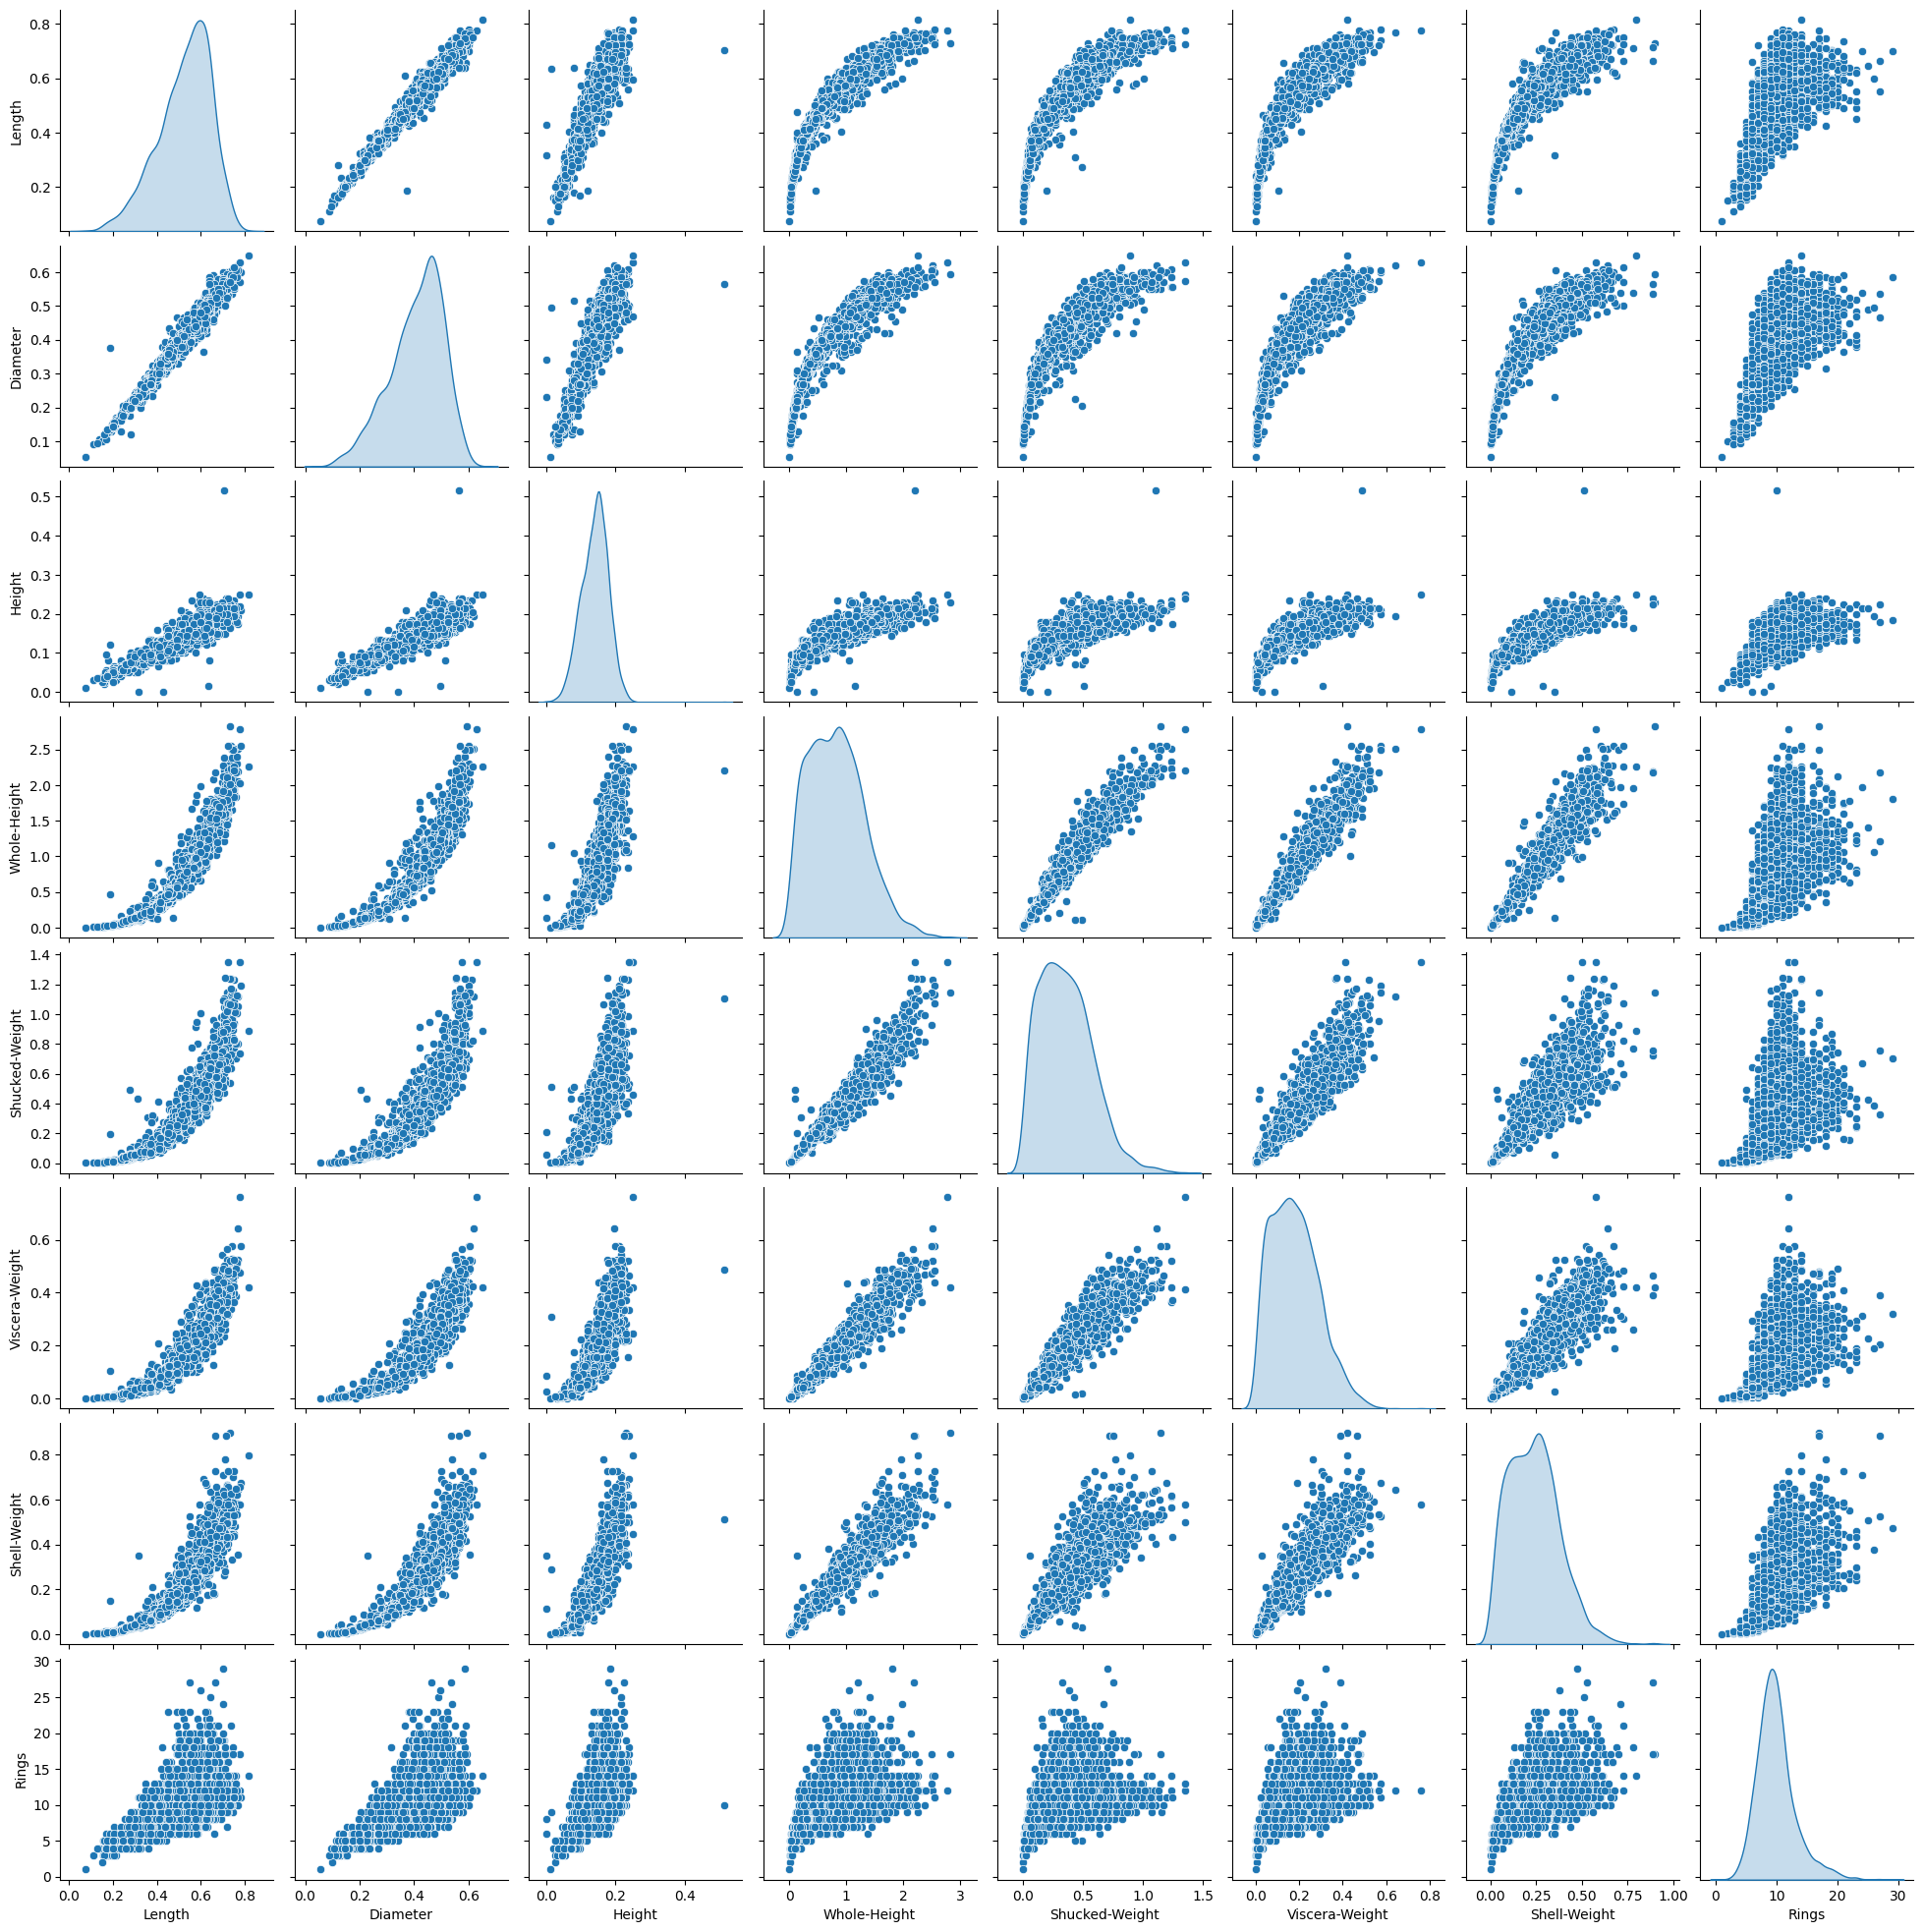

In [59]:
sns.pairplot(train_dataset[['Length', 'Diameter', 'Height', 'Whole-Height', 'Shucked-Weight', 'Viscera-Weight', 'Shell-Weight', 'Rings']], diag_kind="kde")

In [60]:
train_stats = train_dataset.describe()
train_stats.pop("Rings")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Length,3342.0,0.524065,0.119299,0.0750,0.450000,0.54500,0.615000,0.8150
Diameter,3342.0,0.407723,0.098505,0.0550,0.350000,0.42500,0.480000,0.6500
Height,3342.0,0.139455,0.038818,0.0000,0.115000,0.14000,0.165000,0.5150
Whole-Height,3342.0,0.827379,0.488588,0.0020,0.440125,0.79975,1.145000,2.8255
Shucked-Weight,3342.0,0.358846,0.221154,0.0010,0.185625,0.33600,0.499500,1.3510
Viscera-Weight,3342.0,0.180795,0.109585,0.0005,0.093500,0.17050,0.253000,0.7600
Shell-Weight,3342.0,0.238099,0.137449,0.0015,0.130000,0.23375,0.326375,0.8970


Separamos las etiquetas para tener por un lado las de entrenamiento y por otro las de prueba

In [61]:

train_labels = train_dataset.pop('Rings')
test_labels = test_dataset.pop('Rings')

Generamos variables nuevas con la informacion normalizada usando el mean y std proporcionados por los calculos previos

In [62]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Construimos el modelo usando 3 capas, 2 de 64 teniendo 10 de entrada y la de salida

In [63]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [64]:
model = build_model()


/workspace/UPSLP-Chatbot/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,737 (18.50 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

Procedemos a entrenar el modelo generado, usando 1000 iteraciones maximo, asi mismo generamos una funcion de callback para visualizar el proceso usando puntos, y otra para que se detenga antes si no hay mejora en el modelo

In [66]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Graficamos el MAE y el MSE

In [67]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.241532,1.123740,2.241532,6.737292,1.808064,6.737292,995
996,2.216686,1.116005,2.216686,6.951062,1.837177,6.951062,996
997,2.213500,1.113288,2.213500,6.635737,1.824351,6.635737,997
998,2.195776,1.108132,2.195776,7.006908,1.820250,7.006908,998
999,2.230288,1.123618,2.230288,7.064409,1.863042,7.064409,999


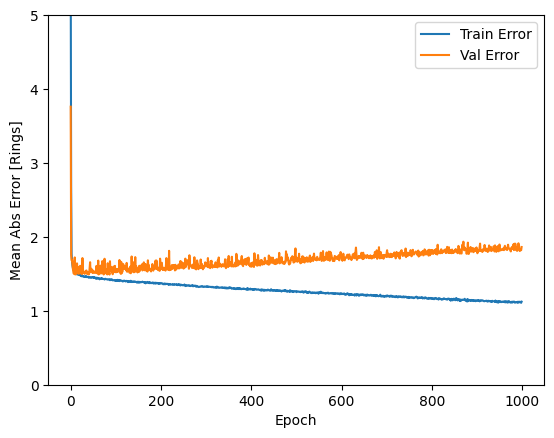

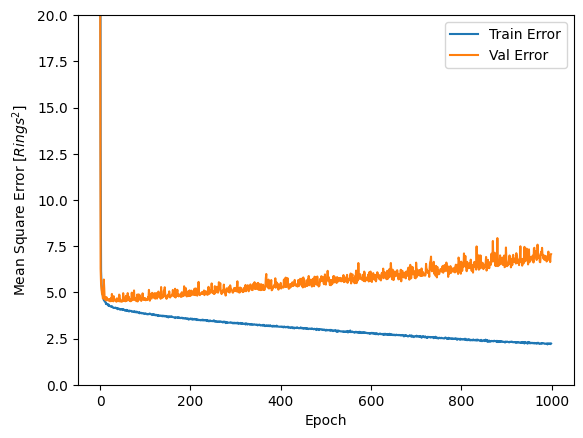

In [68]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Rings]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Rings^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [69]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

27/27 - 0s - 2ms/step - loss: 16.3347 - mae: 1.9249 - mse: 16.3347
Testing set Mean Abs Error:  1.92 MPG


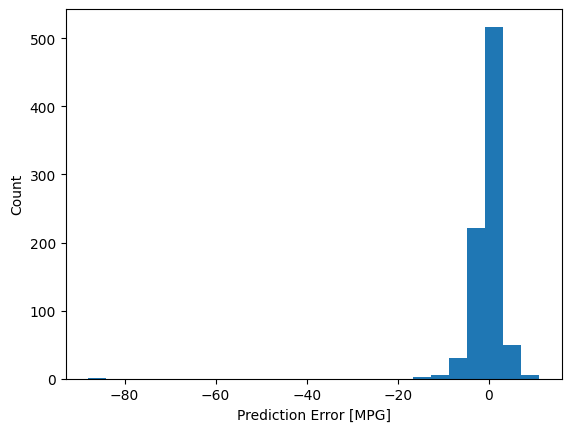

In [72]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")